In [1]:
%pylab inline
import pandas as pd
import numpy as np

import pymc3 as pm 
from pymc3 import math as pmmath 
from pymc3 import Dirichlet
from pymc3.distributions.transforms import t_stick_breaking

import theano 
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

from collections import OrderedDict

theano.config.compute_test_value = 'ignore'

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load cell by gene count matrix with 5 topics and 6 trancriptional states
sim_counts = np.load("./celda_simulated/simCG_counts_Z5K6_copy.npy") 
# load true cell topics 
celda_z = np.load("./celda_simulated/simCG_z_Z5K6_copy.npy")
# load true gene transcriptional states
celda_y = np.load("./celda_simulated/simCG_y_Z5K6_copy.npy")


counts_share = theano.shared(sim_counts)

print("the shape of the count matrix is ({} cell) by ({} gene)".format(*sim_counts.shape))   # cell x gene : 444 x 999
print("length of celda_z is:", len(celda_z))
print("length of celda_y is:", len(celda_y))

the shape of the count matrix is (444 cell) by (999 gene)
length of celda_z is: 444
length of celda_y is: 999


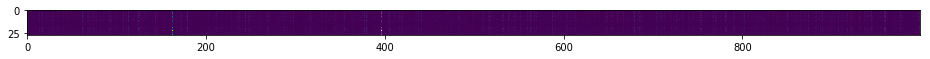

In [3]:
_,  ax = plt.subplots(1, 1, figsize=(16, 5))
ax.imshow(sim_counts[:28]);

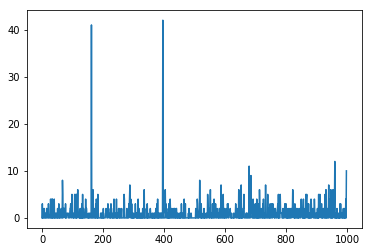

In [4]:
plt.plot(sim_counts[0]);

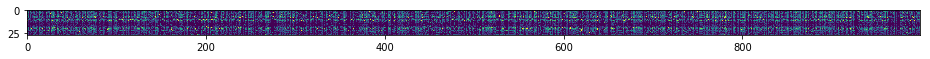

In [5]:
from sklearn import preprocessing
X_scaled = preprocessing.MaxAbsScaler().fit_transform(sim_counts)
_,  ax = plt.subplots(1, 1, figsize=(16, 5))
ax.imshow(X_scaled[:28]);

In [6]:
# define the number of categories for each of the 2 latent variables
n_topics = 5     # 5 topics  -- latent variable 1
n_subppl = 6     # 6 trancriptional states  -- latent variable 2
n_genes = sim_counts.shape[1]

In [7]:
def logp_lda_doc(theta, phi, psi):
    """return the loglikelihood
    Z: number of topics in the model 
    M: number of cells 
    K: number of cellular subpopulation  # i.e., number of transcriptional states
    N: number of genes 
    parameters
    ----------
    theta:  tensor (M x Z)
      Topic distribution for document 
    phi:  tensor (Z x K) 
      Cellular subpopulation distribution within topic
    psi: tensor (K x N)
      Gene distributions. 
    """
    def ll_docs_f(docs):
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        #  loop the inner logsumexp over each topic  (inner logsumexp: within each topic do the logsumexp)
        #  and the results are stored into reuslts1
        results1, updates1 = theano.scan(lambda phi, psi, vixs: 
                             pmmath.logsumexp(tt.log(tt.tile(phi, (vixs.shape[0],1))) +\
                                              tt.log(psi.T[vixs]),
                                              axis=1).ravel(), 
                             sequences=phi, 
                             non_sequences=[psi, vixs])
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log(theta[dixs])+results1.T, axis=1).ravel()
        
        return tt.sum(ll_docs)
    return ll_docs_f


In [8]:
minibatch_size = 28

# defining minibatch
doc_t_minibatch = pm.Minibatch(X_scaled, minibatch_size)
doc_t = shared(X_scaled[:minibatch_size])

In [9]:
with pm.Model() as lda_model:
    theta = Dirichlet("theta", 
                      a=pm.floatX(1.0/n_topics)*np.ones((minibatch_size, n_topics)),
                      shape = (minibatch_size, n_topics), 
                      transform=t_stick_breaking(1e-9) )
    phi = Dirichlet("phi", 
                    a=pm.floatX(1.0/n_topics)*np.ones((n_topics, n_subppl)),
                    shape = (n_topics, n_subppl), 
                    transform=t_stick_breaking(1e-9))
    psi = Dirichlet("psi", 
                    a=pm.floatX(1.0/n_topics)*np.ones((n_subppl, n_genes)),
                    shape = (n_subppl, n_genes), 
                    transform=t_stick_breaking(1e-9) )
    doc = pm.DensityDist('doc', 
                         logp_lda_doc(theta, phi, psi), 
                         observed=doc_t)

In [10]:
###### Auto-Encoding Variational Bayes
## Encoder
class LDAEncoder:
    def __init__(self, n_genes, n_hidden1, n_hidden2, n_topics, n_subppl, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_genes = n_genes
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_topics = n_topics
        self.n_subppl = n_subppl
        self.w0 = shared(0.01 * rng.randn(n_genes, n_hidden1).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden1), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden1, 2 * (n_subppl - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_subppl - 1)), name='b1')
        self.w2 = shared(0.01 * rng.randn(2 * (n_subppl - 1), n_hidden2).ravel(), name='w2')
        self.b2 = shared(0.01 * rng.randn(n_hidden2), name='b2')
        self.w3 = shared(0.01 * rng.randn(n_hidden2, 2 * (n_topics - 1)).ravel(), name='w3')
        self.b3 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b3')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption
    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs
        w0 = self.w0.reshape((self.n_genes, self.n_hidden1))
        w1 = self.w1.reshape((self.n_hidden1, 2 * (self.n_subppl -1) ))
        w2 = self.w2.reshape((2 * (self.n_subppl -1) , self.n_hidden2))   
        w3 = self.w3.reshape((self.n_hidden2, 2 * (n_topics - 1) )) 
        h1s = tt.tanh(xs_.dot(w0) + self.b0)
        ks = h1s.dot(w1) +self.b1
        h2s = tt.tanh(ks.dot(w2) + self.b2)
        zs = h2s.dot(w3) + self.b3

        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}
    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1, self.w2, self.b2 , self.w3, self.b3]


In [11]:
encoder = LDAEncoder(n_genes = n_genes, 
                     n_hidden1=800, n_hidden2=400, 
                     n_topics=n_topics, n_subppl=n_subppl, 
                     p_corruption=0.0)
#vi_encoder = encoder.encode(counts_share)
#local_RVs = OrderedDict([(theta, vi_encoder[:2]), (phi, vi_encoder[2:])])
local_RVs = OrderedDict([(theta, encoder.encode(doc_t))])
local_RVs

OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

In [12]:
encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1, w2, b2, w3, b3]

In [13]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with lda_model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
inference.fit(10000, callbacks=[reduce_rate], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t:doc_t_minibatch})

Average Loss = 35,995: 100%|██████████| 10000/10000 [17:19<00:00,  9.62it/s]
Finished [100%]: Average Loss = 35,996


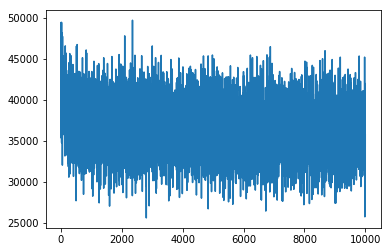

In [14]:
plt.plot(approx.hist);

In [15]:
doc_t.set_value(X_scaled)
trace = pm.sample_approx(approx, draws=1000)

In [16]:
np.shape(trace['theta'])

(1000, 444, 5)

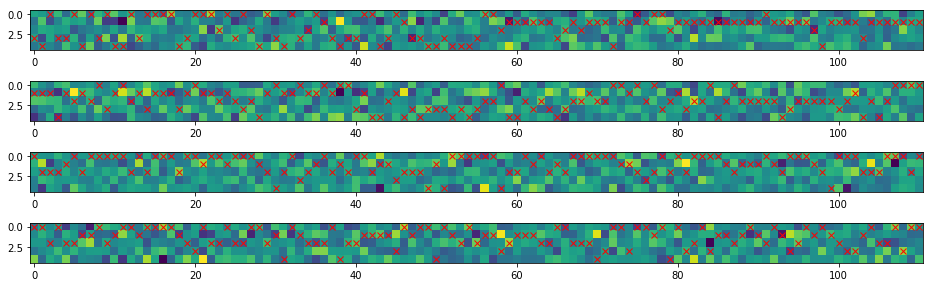

In [21]:
theta_post = trace['theta']
theta_post = theta_post/theta_post.sum(axis=1, keepdims=True)
theta_mean = np.mean(theta_post, axis=0)

nplot = 4
k = np.int16(np.linspace(0, 444, nplot+1))
_,  ax = plt.subplots(nplot, 1, figsize=(16, 5))
for i in range(nplot):
    xrange = np.arange(k[i], k[i+1])
    
    ax[i].imshow(theta_mean[xrange].T);
    ax[i].plot(np.arange(k[i+1]-k[i]), celda_z[xrange]-1, 'rx');

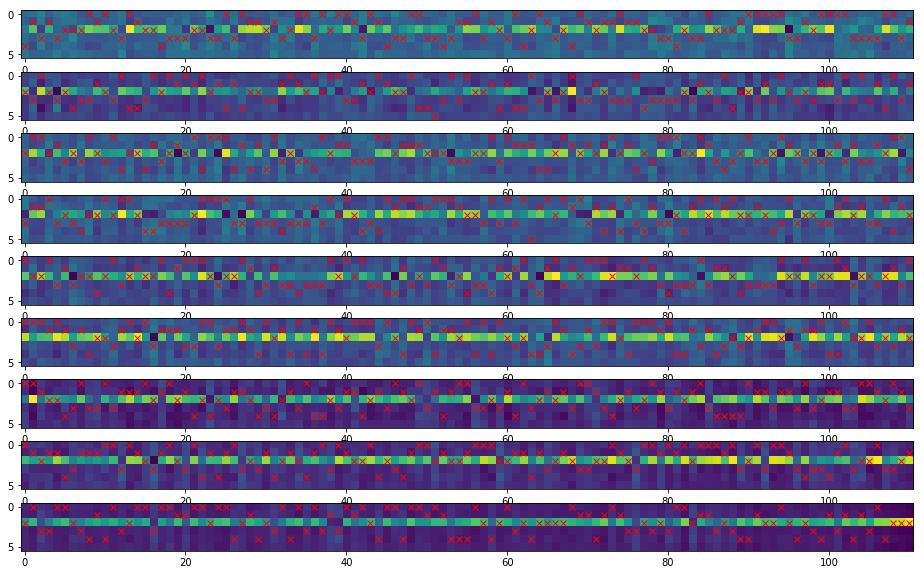

In [22]:
psi_post = trace['psi']
psi_post = psi_post/psi_post.sum(axis=1, keepdims=True)
psi_mean = np.mean(psi_post, axis=0).T

nplot = 9
k = np.int16(np.linspace(0, 999, nplot+1))
_,  ax = plt.subplots(nplot, 1, figsize=(16, 10))
for i in range(nplot):
    xrange = np.arange(k[i], k[i+1])
    
    ax[i].imshow(psi_mean[xrange].T);
    ax[i].plot(np.arange(k[i+1]-k[i]), celda_y[xrange]-1, 'rx');